# Analysis for Trapnell's 271 primary human myoblasts

Aftering obtaining a transcript compatibility count (TCC) distribution matrix, we use the matrix to:

1. Cluster cells via affinity propagation
2. Show the distribution of various clusters in wall clock time
3. Generate the bar plots for visualizing expressions of certain genes within clusters
4. Generate minimum weight spanning trees with pie-charts as nodes

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from collections import Counter
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy


## Running the pipeline and inputting the data matrices

Enter the input paths, and the number of processes to be used

In [52]:
SRA_dir='/data/SS_RNA_seq/Trapnell/SRA_test/'
modified_kallisto_path='/data/SS_RNA_seq/Code/kalliPso_pair'
transcriptome_path='/data/SS_RNA_seq/Trapnell/reference_transcriptome/Homo_sapiens.GRCh38.rel79.cdna.all.fa'
num_processes=32

Run the pipeline. This may take a few hours.

In [54]:
cmd=('python Trapnell_wrapper.py -i '+SRA_dir+' -n ' 
     + str(num_processes)+' -k '+modified_kallisto_path
     +' -t '+transcriptome_path)
os.system(cmd)

Load the relevant data files

In [107]:
with open('./Trapnell_TCC_distribution.dat', 'rb') as infile:
    X = pickle.load(infile)
with open('./Trapnell_TCC_pairwise_distance.dat','rb') as infile:
    D = pickle.load(infile)
Trap_labels=np.loadtxt('./Trapnell_labels.txt',dtype=str)

## Clustering

Two different affinity propagation based clustering to give rise to 3 and 7 clusters

In [57]:
# Clustering is done using scikit-learn's implementation of affinity propagation

from sklearn import cluster
# D is a symmetric N-by-N distance matrix where N is the number of cells
def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

# Jensen-shannon metric used to compute distances
# Distance metrics (input: X with m samples, output: m-by-m distance matrix)
def jensen_shannon(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

Generating 3 clusters from affinity propagation

In [58]:
pref = -1.3*np.ones(271)
labels3=AffinityProp(-D,pref,0.95)

Converged after 73 iterations.


To generate the 7 clusters, we first run affinity propagation to give us 8 clusters and then collapse clusters with  less than 5 cells to the nearest cluste

In [86]:
pref = -.6*np.ones(271)
labels8=AffinityProp(-D,pref,0.95)

Converged after 62 iterations.


Finding the clusters that have to be collapsed

In [62]:
num_cells_in_cluster=Counter(labels8)
clusters_to_collapse=[x for x in np.unique(labels8) if num_cells_in_cluster[x] < 5]

Finding the cluster to collapse into

In [81]:
X_separated=[]
for labl in np.unique(labels8):
    features=X.todense()[np.ix_(np.flatnonzero(labels8==labl),xrange(X.shape[1]))]
    X_separated.append(features)
    
Xcentroid=np.zeros((len(np.unique(labels8)), (X_separated[0].shape)[1]))
for labl in np.unique(labels8):
    Xq=np.sum(X_separated[labl],axis=0)/float((X_separated[labl].shape)[0])
    Xcentroid[labl, :]=Xq
    
Dcentroid = pairwise_distances(Xcentroid,metric=jensen_shannon)

cluster_to_collapse_into=[np.argsort(Dcentroid[clusters_to_collapse[0],:])[1]]

Collapsing the cluster with less than 5 elements                            

In [88]:
labels7=np.array(labels8)
labels7[labels8==clusters_to_collapse[0]]=cluster_to_collapse_into[0]
labels7[labels8>clusters_to_collapse[0]]-=1

## Distribution of the 3 clusters in wall clock time

We note that cells 0-68 corresponded to 0 hours, cells 69-142 corresponded to 24 hours, cells 143-212 corresponded to 48 hours, and cells 213-270 corresponded to 72 hours

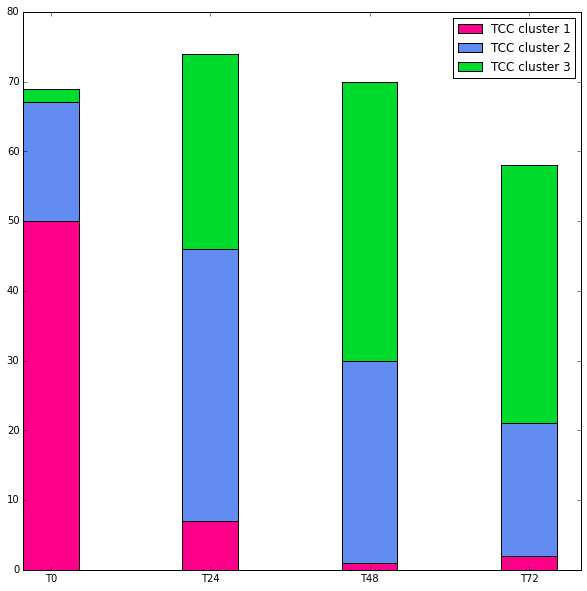

In [101]:
%matplotlib inline
Tr0 = Counter(labels3[:69])
Tr24 = Counter(labels3[69:143])
Tr48 = Counter(labels3[143:213])
Tr72 = Counter(labels3[213:])

ind=np.arange(4)
width = 0.35

Cr0=np.array([Tr0[0], Tr24[0], Tr48[0], Tr72[0]])
Cr1=np.array([Tr0[1], Tr24[1], Tr48[1], Tr72[1]])
Cr2=np.array([Tr0[2], Tr24[2], Tr48[2], Tr72[2]])

plt.figure(figsize=(10,10))
p1 = plt.bar(ind, Cr1, width, color="#ff008a")
p3 = plt.bar(ind, Cr0, width, color="#628cf2",bottom=Cr1)
p2 = plt.bar(ind, Cr2, width, color="#01db2e",bottom=Cr0+Cr1)


plt.xticks(ind + width/2., ('T0', 'T24', 'T48', 'T72'))
plt.legend((p1[0], p3[0],p2[0]), ('TCC cluster 1', 'TCC cluster 2',
                                 'TCC cluster 3'))

## Minimum weight spanning tree (MST)

We run an MST in high dimensions on the cluster centers and on the original cells.

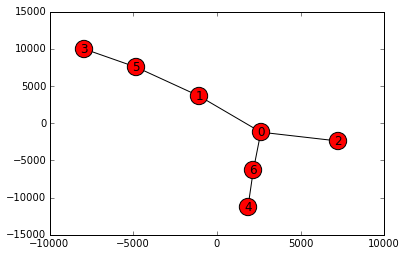

In [106]:
X_separated=[]
for labl in np.unique(labels7):
    features=X.todense()[np.ix_(np.flatnonzero(labels7==labl),xrange(X.shape[1]))]
    X_separated.append(features)
    
Xcentroid=np.zeros((len(np.unique(labels7)), (X_separated[0].shape)[1]))
for labl in np.unique(labels7):
    Xq=np.sum(X_separated[labl],axis=0)/float((X_separated[labl].shape)[0])
    Xcentroid[labl, :]=Xq
    
Dcentroid = pairwise_distances(Xcentroid,metric=jensen_shannon)


G = nx.complete_graph(len(np.unique(labels7)))
for u,v in G.edges():
    G[u][v]["weight"]=Dcentroid[u,v]
    
T=nx.minimum_spanning_tree(G)
pos=nx.spring_layout(T,scale=10000)
nx.draw_networkx(T,pos)
edge_labels=dict([((u,v,),round(d['weight'],2))
             for u,v,d in T.edges(data=True)])


Next we show the distribution of Trapnell's true labels on our tree here

In [133]:
def draw_pie_MST(T,Ltrue,Labels,piesize=0.05,c= ["#ff008a","#628cf2","#01db2e"],
                 Ltrue_unique=['Proliferating cell','Differentiating myoblast',
                               'Interstitial mesenchymal cell'],leg=True,show_clust_names=False):
    pos=nx.spring_layout(T)
    fig=plt.figure(figsize=(15,15))
    #ax=plt.axes([0,0,1,1])
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(T,pos,ax=ax)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    p2=piesize/2.0
    max_p = 0
    for n in T:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        Ltemp = Ltrue[Labels == n]
        # Save proportion of each label
        fracs = []
        tot_size = float(len(Ltemp))
        for label in np.unique(Ltrue):
            fracs.append(np.sum(Ltemp == label)/tot_size)
        fracs = np.array(fracs)
        # Account for case where pie should only contain one color 
        if np.sum(fracs != 0) == 1: 
            ind = np.where(fracs != 0)[0]
            fracs = [fracs[ind]]
            ctemp = [c[ind]]
        else: 
            ctemp = c
        p,_ = a.pie(fracs,colors=ctemp,shadow=True)
        if len(p) > max_p: 
            patches = p
            max_p = len(p)
        if show_clust_names: plt.title(n)
    if leg: plt.legend(patches, Ltrue_unique, bbox_to_anchor=(6, 1))
    plt.show()

We now show the distribution of Trapnell et al.'s labels as distributed over our 7 labels

/home/govinda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


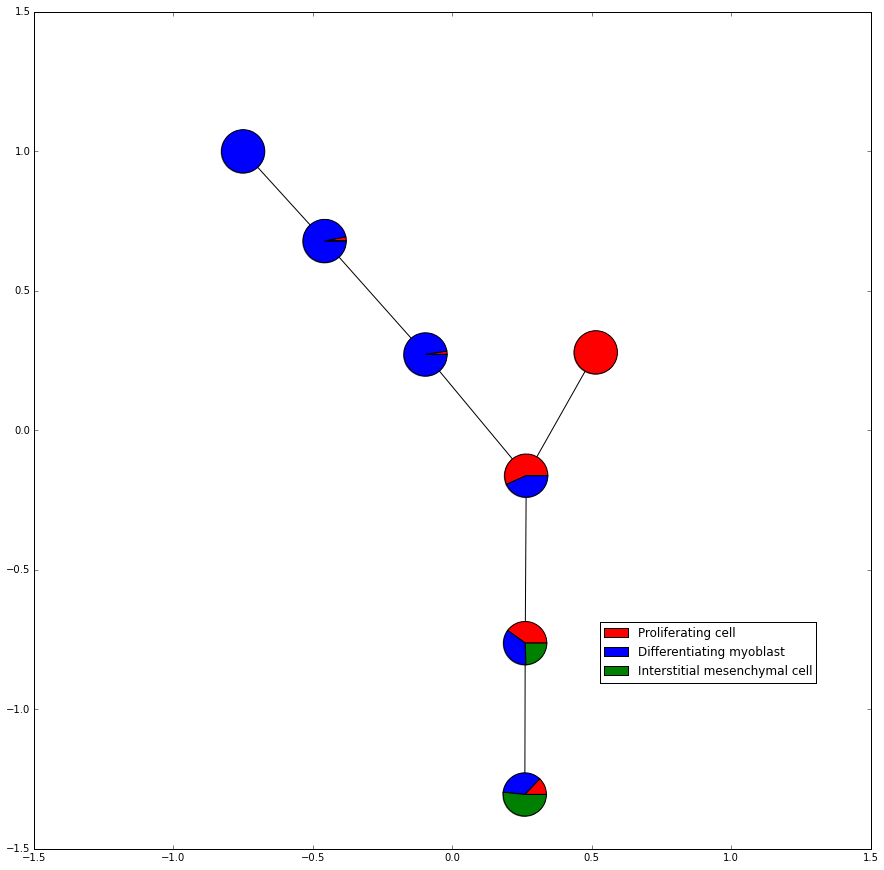

In [139]:
draw_pie_MST(T,Trap_labels,labels7,c=['r','b','g'],
             leg=True,show_clust_names=False)


We next show our the distribution of our 3 labels with respect to our 7 labels

draw_pie_MST(T,labels3,labels7,Ltrue_unique=['TCC cluster 1','TCC cluster 2','TCC cluster 3'],
             leg=True,show_clust_names=False)

Next we show the clustering of high dimensional TCC distributions, and see that it does not seem to give interpretable results

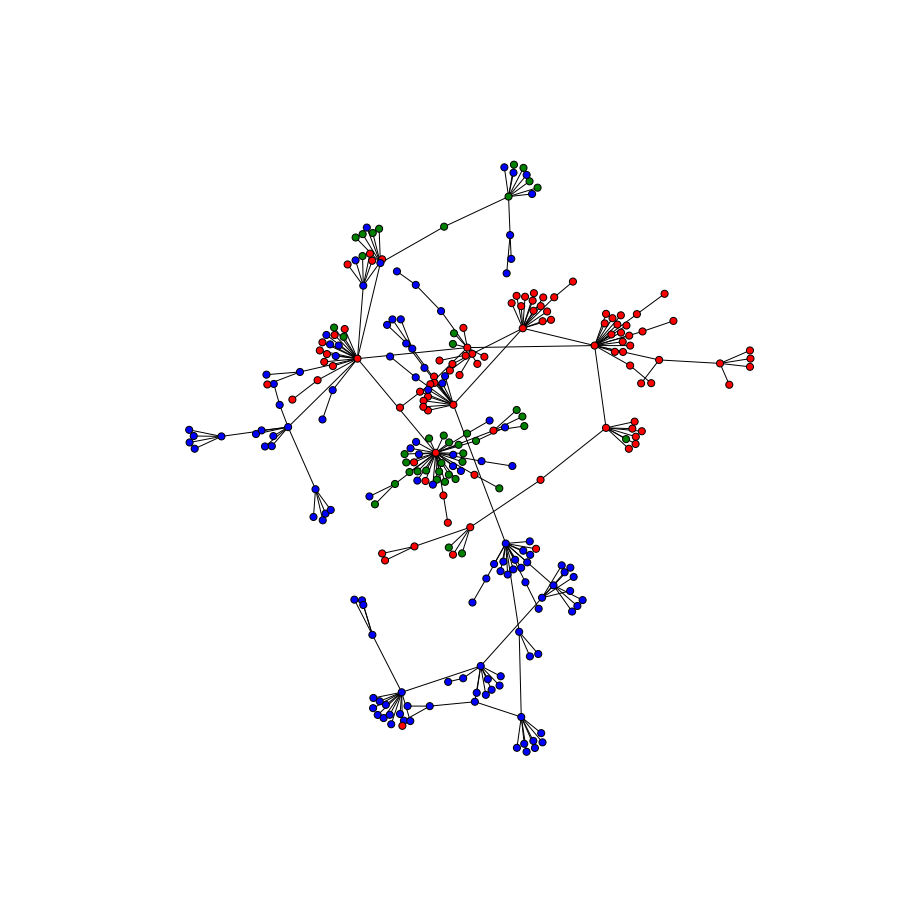

In [143]:
Ghd = nx.complete_graph(271)
for u,v in Ghd.edges():
    Ghd[u][v]["weight"]=D[u,v]
Thd=nx.minimum_spanning_tree(Ghd)
colour={'1': 'red', '2': 'blue', '3':'green'}
vals=map(lambda x: colour[x],Trap_labels )
plt.figure(3,figsize=(12,12)) 
pos=nx.spring_layout(Thd,scale=10)
nx.draw(Thd,node_size=50,node_color=vals,pos=pos)
plt.show()

## Bar plot

We draw bar plots showing variation of MYOG, PDGFRA, and CDK1 over the clusters obtained from affinity propagation.

First we show the variation of TPMs across the 7 clusters. The TPM expression is obtained from Trapnell et al.'s dataset.

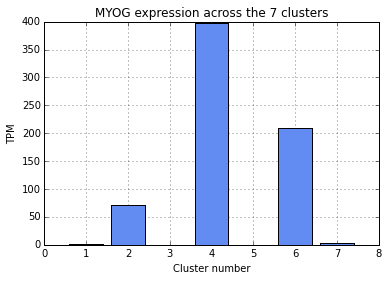

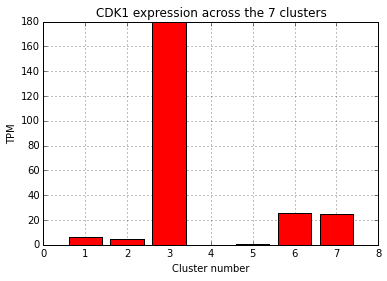

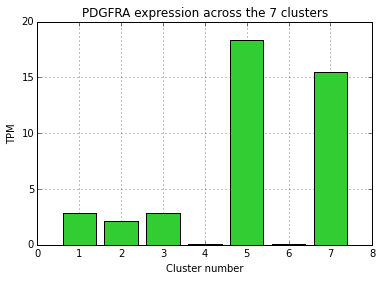

In [168]:
MYOG=np.loadtxt('./MYOG_TPM.txt')
MYOG7=[]
for index in np.unique(labels7):
    MYOG7.append(np.average(MYOG[labels7==index])*10**6)

CDK1=np.loadtxt('./CDK1_TPM.txt')
CDK1_7=[]
for index in np.unique(labels7):
    CDK1_7.append(np.average(CDK1[labels7==index])*10**6)
    
PDGFRA=np.loadtxt('./PDGFRA_TPM.txt')
PDGFRA7=[]
for index in np.unique(labels7):
    PDGFRA7.append(np.average(PDGFRA[labels7==index])*10**6)

plt.bar(range(1,8),MYOG7,color='#628cf2',zorder=4,align='center')
plt.title('MYOG expression across the 7 clusters')
plt.grid()
plt.xlabel('Cluster number')
plt.ylabel('TPM')
plt.show()

plt.bar(range(1,8),CDK1_7,color='r',zorder=4,align='center')
plt.title('CDK1 expression across the 7 clusters')
plt.grid()
plt.xlabel('Cluster number')
plt.ylabel('TPM')
plt.show()

plt.bar(range(1,8),PDGFRA7,color='limegreen',zorder=4,align='center')
plt.title('PDGFRA expression across the 7 clusters')
plt.grid()
plt.xlabel('Cluster number')
plt.ylabel('TPM')
plt.show()

Next we show the number of cells showing an expression of the MYOG, CDK1, and  in our 

In [185]:
MYOG=np.loadtxt('./MYOG_FPKM.txt')
CDK1=np.loadtxt('./CDK1_FPKM.txt')
PDGFRA=np.loadtxt('./PDGFRA_FPKM.txt')

MYOG_log=np.log(np.ones_like(MYOG) + MYOG)
CDK1_log=np.log(np.ones_like(CDK1) + CDK1)
PDGFRA_log=np.log(np.ones_like(PDGFRA) + PDGFRA)
MYOG3=[]
CDK1_3=[]
PDGFRA3=[]
for index in np.unique(labels3):
    MYOG3.append(np.count_nonzero(MYOG_log[labels3==index] > 1)/float(len(MYOG_log[[labels3==index]])))

In [186]:
MYOG3

[0.41346153846153844, 0.016666666666666666, 0.06542056074766354]